In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
from comparers import ModelComparer
from explainers import generate_shap_explanations
from plots import plot_decision_boundary, plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                  plot_feature_effects, plot_forces
from util import calc_feature_order, calc_class_order, calc_instance_order
import pandas as pd
import diro2c
from data_generation.helper import prepare_df
from data_generation.neighborhood_generation import neighbor_generator
from enums.diff_classifier_method_type import diff_classifier_method_type
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
import rule_extractor
shap.initjs()
%matplotlib inline
task_name = '04'

In [2]:
with open(task_name + '.dataset', 'rb') as f:
    X, y, feature_names = pickle.load(f)
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)

# Explain using Interpretability Methods

Prepare dataset for diro2c

In [3]:
idx_explain = 0

In [4]:
feature1 = []
feature2 = []
for x in X:
    feature1.append(x[0])
    feature2.append(x[1])

feature1 = np.asarray(feature1)
feature2 = np.asarray(feature2)

y = y.astype(str)

d = {'y': y, 'feature_1': feature1, 'feature_2': feature2}

df = pd.DataFrame(d)

dataset = prepare_df(df, 'test', 'y')

## Binary difference explanations

In [5]:
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.binary_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood)

In [6]:
dc_info = diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([0, 1]), array([1969,  131]))


Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


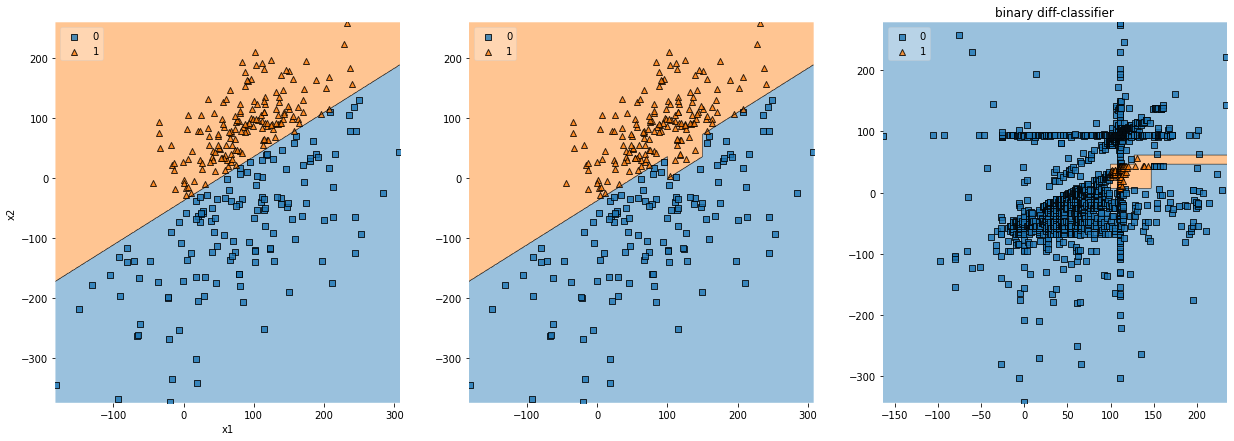

In [7]:
y_pred_a = comparer.clf_a.predict(X)
y_pred_b = comparer.clf_b.predict(X)

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(
    np.int64), clf=comparer.clf_a, ax=ax[0], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('blackbox 1')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(
    np.int64), clf=comparer.clf_b, ax=ax[1], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('blackbox 2')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(
    np.integer), clf=dc_full, ax=ax[2], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('binary diff-classifier')

plt.show()

[Text(422.72727272727275, 855.6666666666666, 'x1 <= 99.5\ngini = 0.117\nsamples = 2100\nvalue = [1969, 131]\nclass = no_diff'),
 Text(338.1818181818182, 755.0, 'gini = 0.0\nsamples = 1144\nvalue = [1144, 0]\nclass = no_diff'),
 Text(507.27272727272725, 755.0, 'x2 <= 45.0\ngini = 0.237\nsamples = 956\nvalue = [825, 131]\nclass = no_diff'),
 Text(253.63636363636363, 654.3333333333333, 'x2 <= 6.5\ngini = 0.479\nsamples = 327\nvalue = [197, 130]\nclass = no_diff'),
 Text(169.0909090909091, 553.6666666666666, 'gini = 0.0\nsamples = 189\nvalue = [189, 0]\nclass = no_diff'),
 Text(338.1818181818182, 553.6666666666666, 'x1 <= 146.5\ngini = 0.109\nsamples = 138\nvalue = [8, 130]\nclass = diff'),
 Text(253.63636363636363, 453.0, 'x2 <= 42.5\ngini = 0.015\nsamples = 131\nvalue = [1, 130]\nclass = diff'),
 Text(169.0909090909091, 352.33333333333326, 'gini = 0.0\nsamples = 99\nvalue = [0, 99]\nclass = diff'),
 Text(338.1818181818182, 352.33333333333326, 'x1 <= 111.5\ngini = 0.061\nsamples = 32\nval

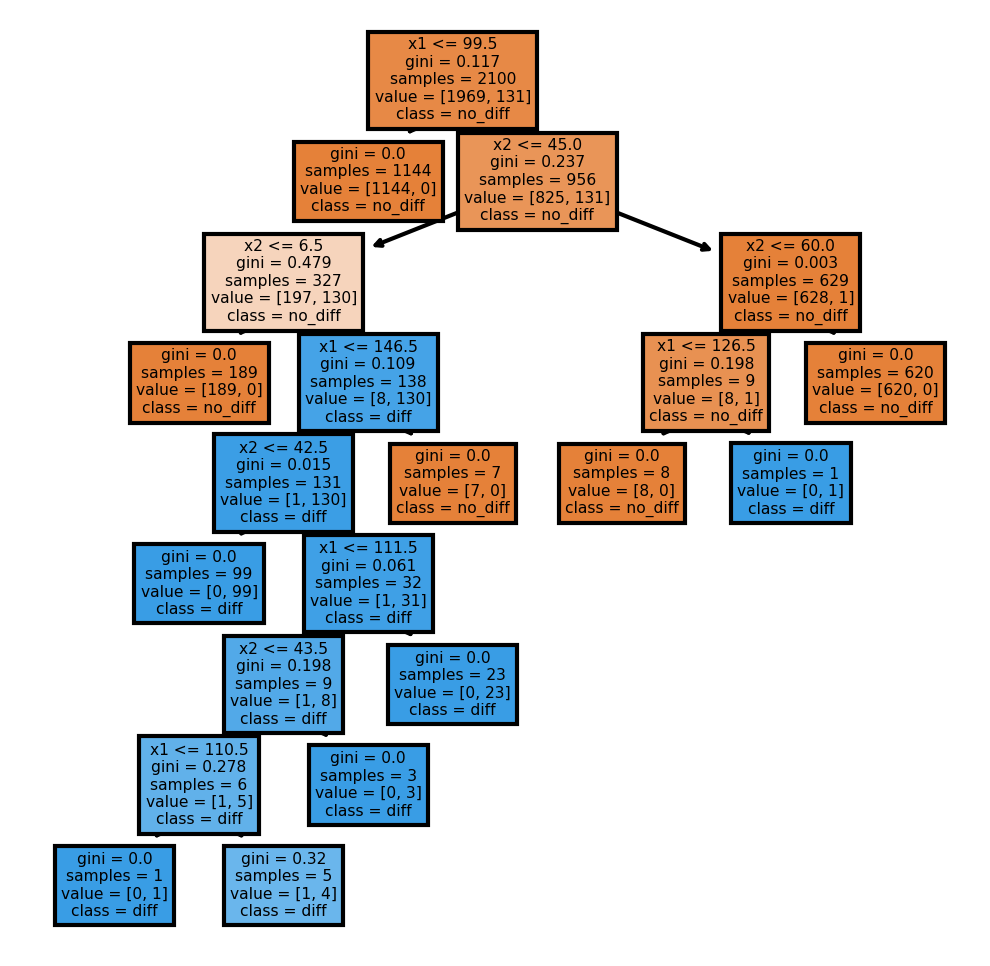

In [8]:
cn = ['no_diff', 'diff']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=cn,
               filled=True)

In [9]:
rule_extractor.print_rules_for_binary(
    dc_full, dataset['columns_for_decision_rules'], ['no_diff', 'diff'], 'diff')

{'diff': '{feature_1 > 99.5, feature_2 <= 45.0, feature_2 > 6.5, feature_1 <= 146.5, feature_2 <= 42.5}'}
{'diff': '{feature_1 > 99.5, feature_2 <= 45.0, feature_2 > 6.5, feature_1 <= 146.5, feature_2 > 42.5, feature_1 <= 111.5, feature_2 <= 43.5, feature_1 <= 110.5}'}
{'diff': '{feature_1 > 99.5, feature_2 <= 45.0, feature_2 > 6.5, feature_1 <= 146.5, feature_2 > 42.5, feature_1 <= 111.5, feature_2 <= 43.5, feature_1 > 110.5}'}
{'diff': '{feature_1 > 99.5, feature_2 <= 45.0, feature_2 > 6.5, feature_1 <= 146.5, feature_2 > 42.5, feature_1 <= 111.5, feature_2 > 43.5}'}
{'diff': '{feature_1 > 99.5, feature_2 <= 45.0, feature_2 > 6.5, feature_1 <= 146.5, feature_2 > 42.5, feature_1 > 111.5}'}
{'diff': '{feature_1 > 99.5, feature_2 > 45.0, feature_2 <= 60.0, feature_1 > 126.5}'}


## Multiclass difference explanations

In [10]:
multiclass_diff_names = ['(0, 0)', '(1, 1)', '(1, 0)', '(0, 1)']

In [11]:
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.multiclass_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood)

In [12]:
dc_info = diff_classifiers_info['multiclass_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([1, 2, 4]), array([1400,  730,  134]))


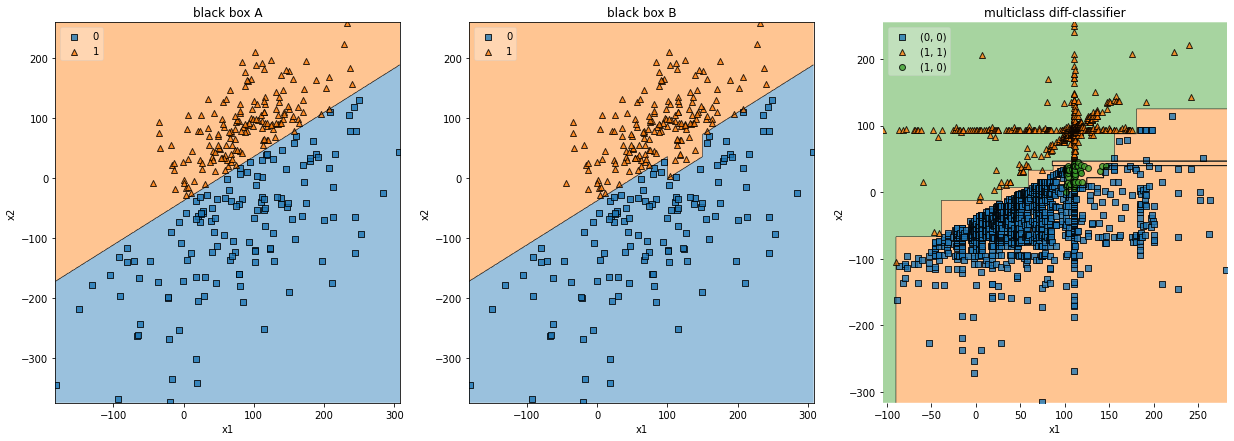

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(
    np.int64), clf=comparer.clf_a, ax=ax[0], legend=2, hide_spines=False)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
ax[0].set_title('black box A')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(
    np.int64), clf=comparer.clf_b, ax=ax[1], legend=2, hide_spines=False)
ax[1].set_xlabel(feature_names[0])
ax[1].set_ylabel(feature_names[1])
ax[1].set_title('black box B')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(
    np.int64), clf=dc_full, ax=ax[2], legend=2)
ax[2].set_xlabel(feature_names[0])
ax[2].set_ylabel(feature_names[1])
ax[2].set_title('multiclass diff-classifier')

handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles,
             multiclass_diff_names,
             framealpha=0.3, scatterpoints=1)

plt.show()


[Text(489.05172413793105, 855.6666666666666, 'x2 <= 39.5\ngini = 0.51\nsamples = 2264\nvalue = [1400, 730, 134]\nclass = (0, 0)'),
 Text(256.55172413793105, 755.0, 'x2 <= 6.5\ngini = 0.172\nsamples = 1531\nvalue = [1388, 21, 122]\nclass = (0, 0)'),
 Text(96.20689655172414, 654.3333333333333, 'x1 <= -89.5\ngini = 0.011\nsamples = 1312\nvalue = [1305, 6, 1]\nclass = (0, 0)'),
 Text(64.13793103448276, 553.6666666666666, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]\nclass = (1, 1)'),
 Text(128.27586206896552, 553.6666666666666, 'x1 <= -39.0\ngini = 0.009\nsamples = 1311\nvalue = [1305, 5, 1]\nclass = (0, 0)'),
 Text(64.13793103448276, 453.0, 'x2 <= -67.0\ngini = 0.102\nsamples = 37\nvalue = [35, 2, 0]\nclass = (0, 0)'),
 Text(32.06896551724138, 352.33333333333326, 'gini = 0.0\nsamples = 35\nvalue = [35, 0, 0]\nclass = (0, 0)'),
 Text(96.20689655172414, 352.33333333333326, 'gini = 0.0\nsamples = 2\nvalue = [0, 2, 0]\nclass = (1, 1)'),
 Text(192.41379310344828, 453.0, 'x2 <= -11.5\ngini = 0.0

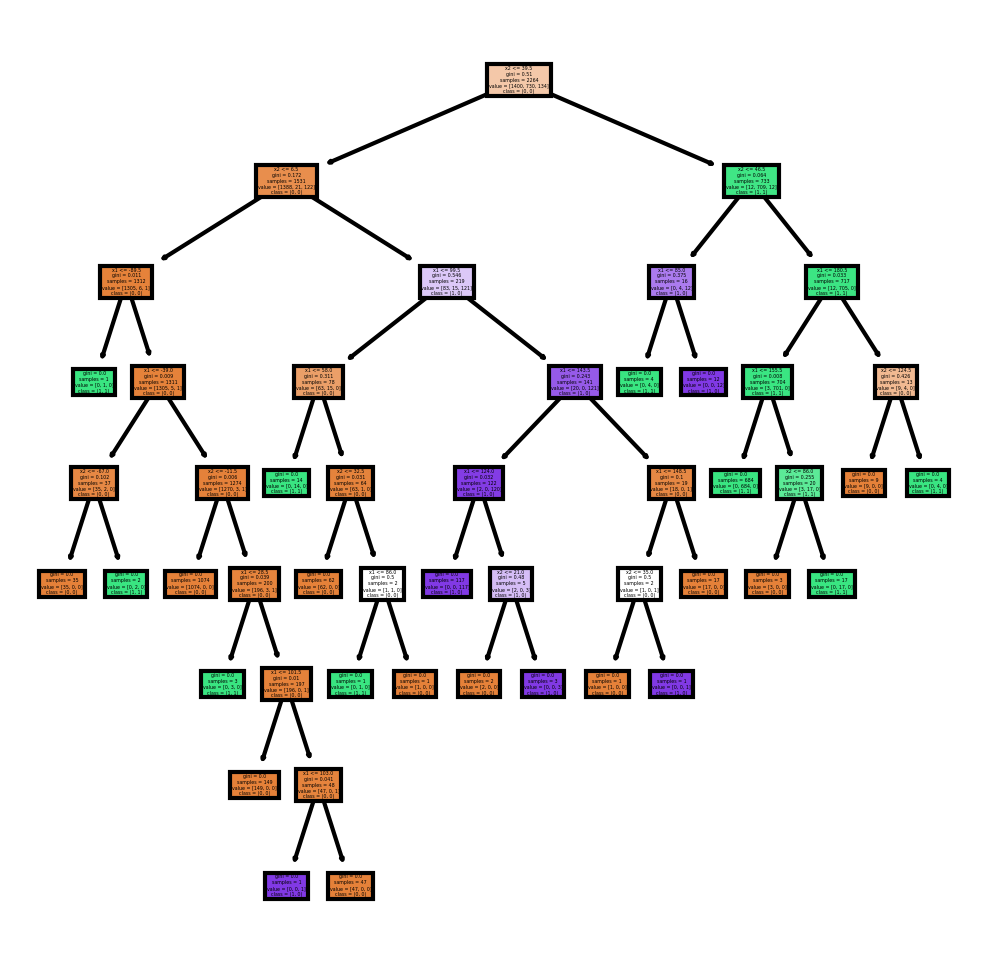

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=multiclass_diff_names,
               filled=True)